# Домашнее задание №2

## Датасет diabetes.csv

### Автор: Юматов Владимир Константинович

#### группа 19.Б11-мм

# Задание

- [x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [x] Взять данные для предсказания заболеваний сердца (целевой признак для предсказания --- target).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).
- [x] Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).
- [x] Используя подбор гиперпараметров, кросс-валидацию и при необходимости масштабирование данных, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [x] Повторить предыдущий пункт для библиотечных реализаций (например, из sklearn) всех пройденных методов классификации (logistic regression, svm, knn, naive bayes, decision tree).
- [x] Сравнить все обученные модели, построить их confusion matrices. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [x] Реализовать еще один из методов классификации и добавить его в сравнение.
- [x] Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

## Второй датасет

[Датасет](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#) - данные по заболеваемости диабетом. 

**Pregnancies**: количество беременностей

**Glucose**: уровень глюкозы в крови

**BloodPressure**: давление

**SkinThickness**: толщина кожи

**Insulin**: уровень инсулина в крови

**BMI**: индекс массы тела

**DiabetesPedigreeFunction**: вероятность проявления болезни из-за наследствености

**Age**: возраст

Целевой признак:

**Outcome**: диагноз (1 - да, 0 - нет)

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_validate,
    GridSearchCV,
    StratifiedKFold,
)
from math import inf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier

In [5]:
df2 = pd.read_csv("./diabetes.csv")
df2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


На первый взгляд проблем с данными нет: все целое, нулевых значений нет

In [7]:
df2.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Есть странные данные в нескольких параметрах: тощина кожи или идекс массы тела ноль. [Оказалось](https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset/discussion/363299), что null-данные были заменены в датасете нулями (поэтому их не было на предыдущем шаге). Такая практика не очень хорошая, так что удалим строки со странными данными.

In [8]:
df2.drop(df2[(df2["SkinThickness"] == 0)].index, inplace=True)
df2.drop(df2[(df2["Glucose"] == 0)].index, inplace=True)
df2.drop(df2[(df2["Insulin"] == 0)].index, inplace=True)
df2.drop(df2[(df2["BMI"] == 0)].index, inplace=True)

Отлично, данные почищены. Теперь посмотрим на статистику по целевому признаку.

In [9]:
df2["Outcome"].value_counts()

0    262
1    130
Name: Outcome, dtype: int64

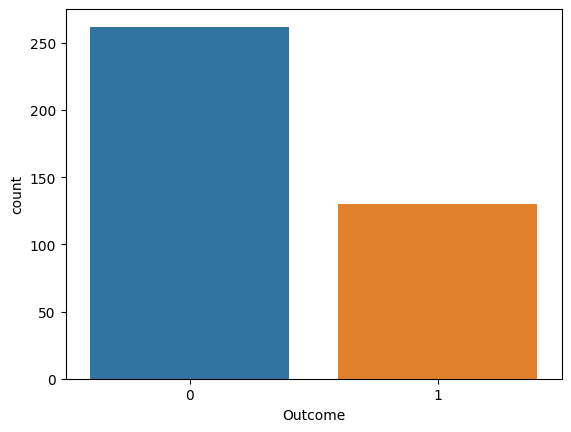

In [10]:
sns.countplot(x="Outcome", data=df2);

In [11]:
df2["Outcome"].mean()

0.33163265306122447

У 33% пациентов был найден диабет. Посмотрим как связан целевой признак с нецелевыми

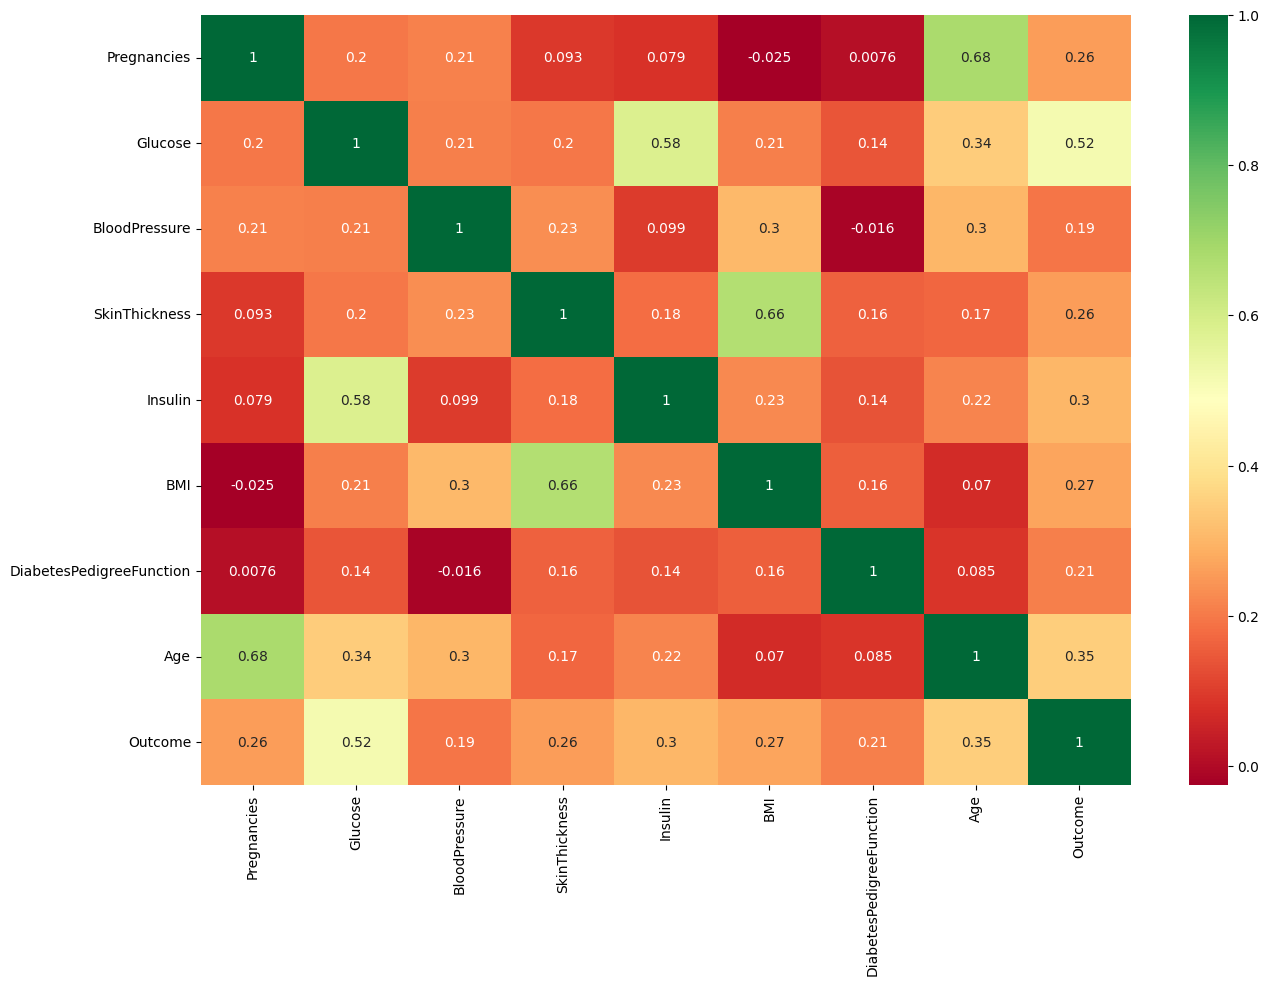

In [12]:
sns.heatmap(df2.corr(), annot=True, cmap="RdYlGn")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

Наблюдается средняя корреляция между **pregnancies** и **age**, между **skinthickness** и **bmi**. 

Самая сильная корреляция целевого признака с **glucose**

### Количественный признак **age**

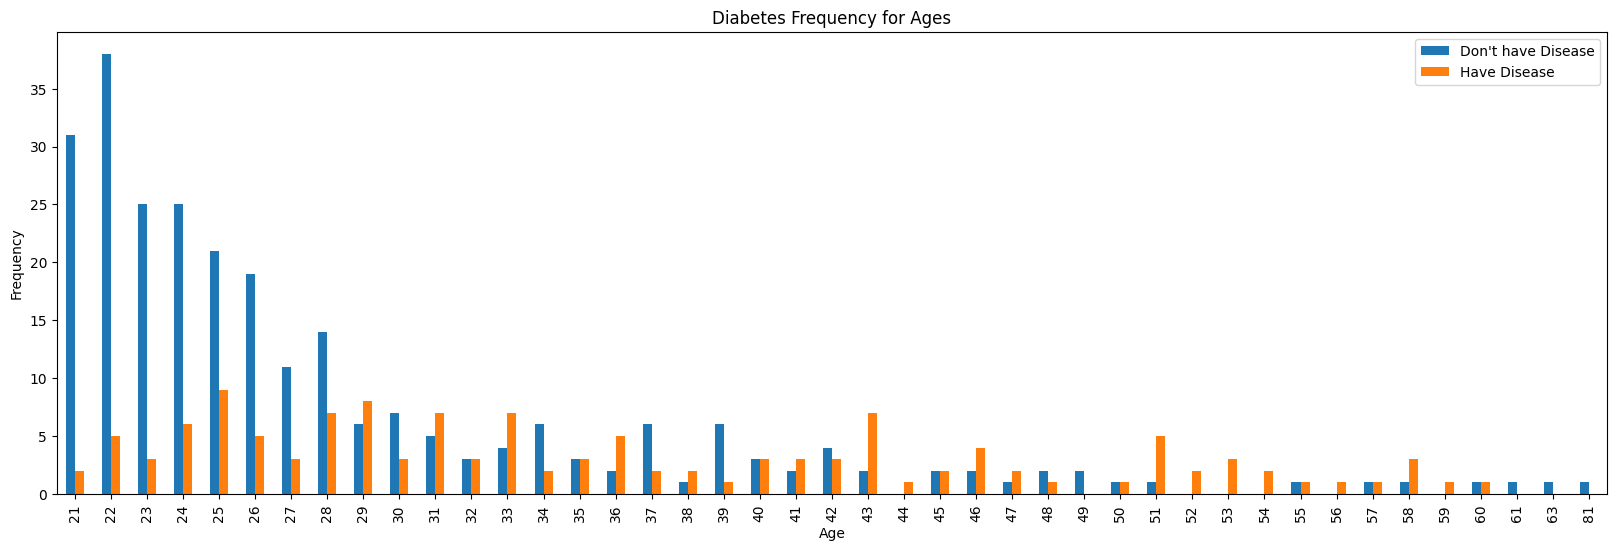

In [13]:
pd.crosstab(df2.Age, df2.Outcome).plot(kind="bar", figsize=(20, 6))
plt.title("Diabetes Frequency for Ages")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend(["Don't have Disease", "Have Disease"])
plt.show()

Для пациентов 21-28 лет процент людей, которые не болеют сильно выше, чем для людей 28+. Для людей 51-54 лет заметно обратное: люди чаще получают диагноз диабет.

Также стоит отметить, что данных для молодых девушек больше, чем для более взрослых возрастов.

### Количественный признак **pregnancies**

In [14]:
df2["Pregnancies"].value_counts()

1     93
2     64
0     56
3     45
4     27
5     21
7     20
6     19
8     14
9     11
10     6
11     5
12     5
13     3
15     1
17     1
14     1
Name: Pregnancies, dtype: int64

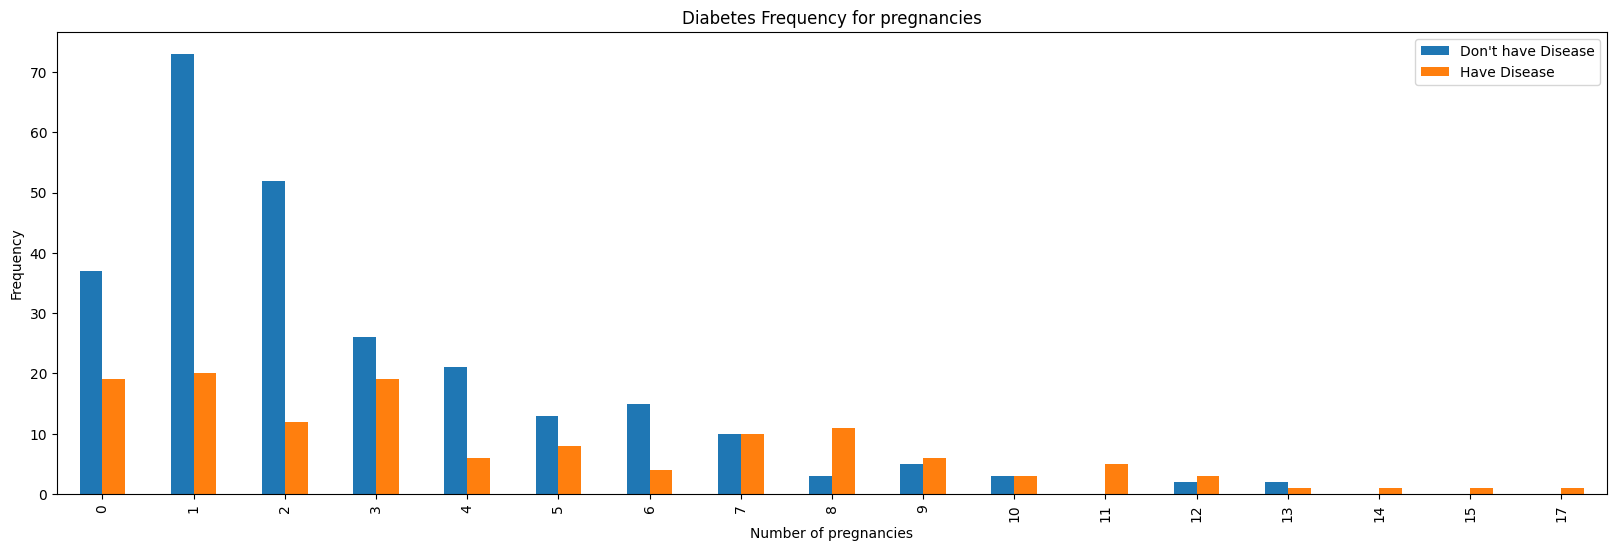

In [15]:
pd.crosstab(df2.Pregnancies, df2.Outcome).plot(kind="bar", figsize=(20, 6))
plt.title("Diabetes Frequency for pregnancies")
plt.xlabel("Number of pregnancies")
plt.ylabel("Frequency")
plt.legend(["Don't have Disease", "Have Disease"])
plt.show()

У женщин, которые перенесли больше чем 6 беременностей, выше вероятность заболеть диабетом. При этом все женщины, у которых было больше 13 беременностей, болеют диабетом, но, к сожалению, слишком мало данных, чтобы делать какие-то точные выводы.

### Количественный признак **glucose** и **insulin**

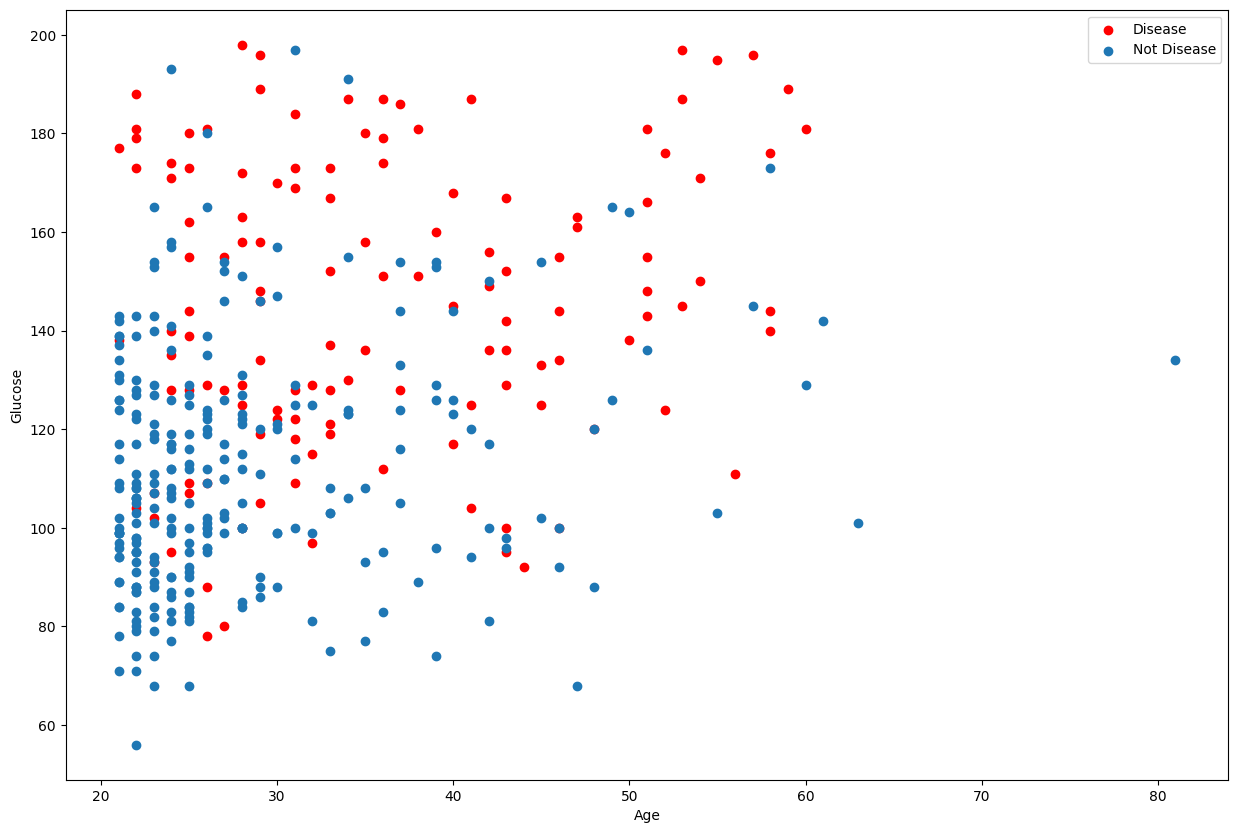

In [16]:
plt.scatter(x=df2.Age[df2.Outcome == 1], y=df2.Glucose[(df2.Outcome == 1)], c="red")
plt.scatter(x=df2.Age[df2.Outcome == 0], y=df2.Glucose[(df2.Outcome == 0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Glucose")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

* При показаниях выше 150 для всех возрастов 
риск болезни диабетом очень высокий

* У людей, старше 30 лет, диабет чаще наблюдается и при показаниях меньше 150


Теперь посмотрим на зависимость глюкозы от инсулина

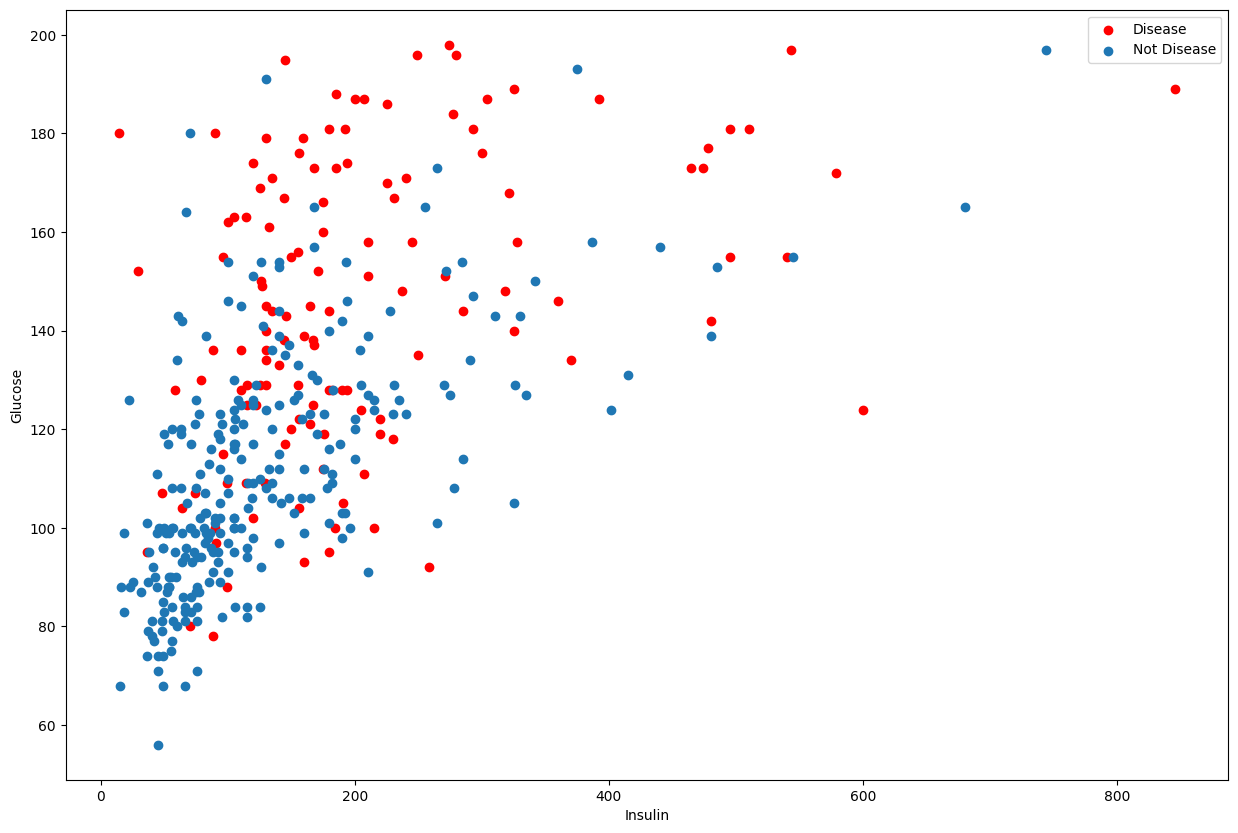

In [17]:
plt.scatter(x=df2.Insulin[df2.Outcome == 1], y=df2.Glucose[(df2.Outcome == 1)], c="red")
plt.scatter(x=df2.Insulin[df2.Outcome == 0], y=df2.Glucose[(df2.Outcome == 0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Insulin")
plt.ylabel("Glucose")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

Действительно, можно заметить некую корреляцию между значениями: при повышении инсулина видно повышение глюкозы (это сходится и с биологией, инсулин способствует всасыванию глюкозы). 

При этом, здоровые пациенты в основном сконцентрированы в низких показаниях инсулина с присутствием нескольких заболевших.
Это тоже логично, так как считается, что 1 тип диабета составляют 5%, а 2 (с повышенным уровнем диабета) 95% больных.

### Количественный признак **blood pressure**

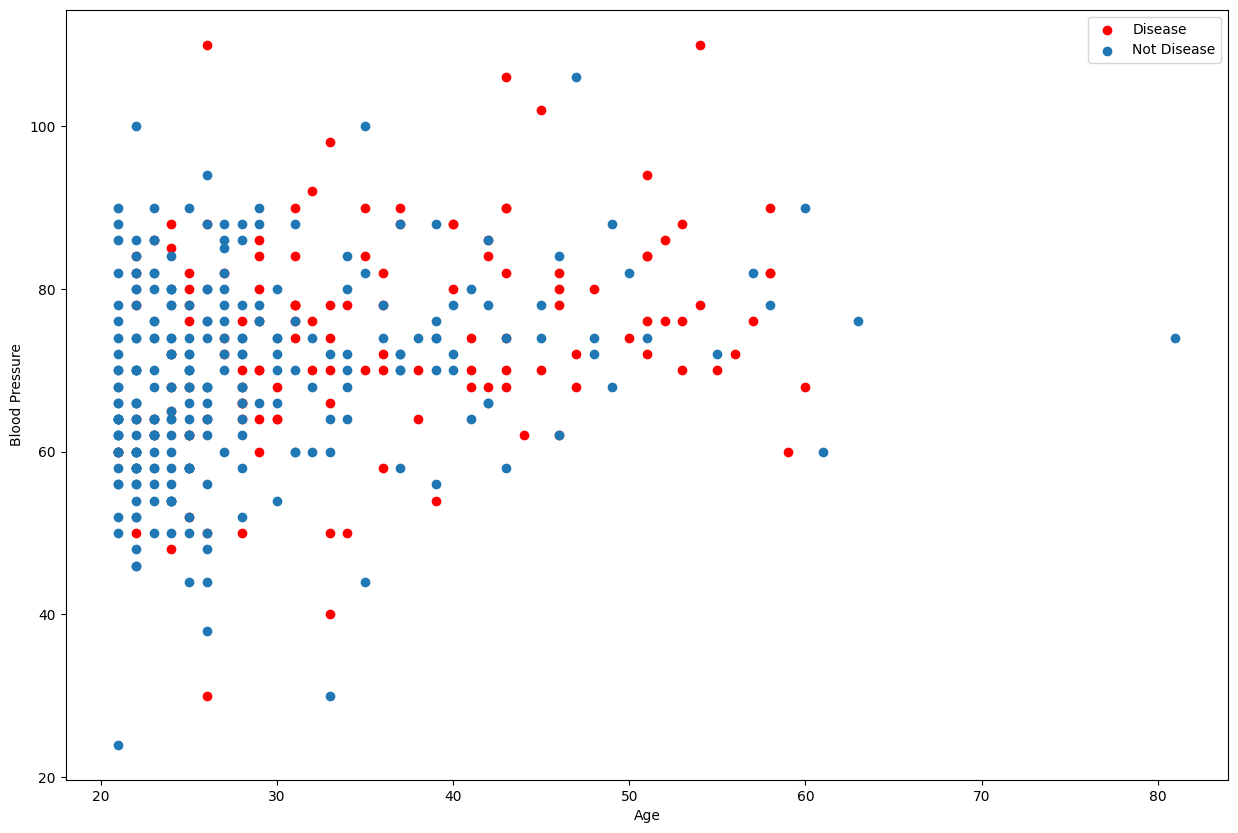

In [18]:
plt.scatter(
    x=df2.Age[df2.Outcome == 1], y=df2.BloodPressure[(df2.Outcome == 1)], c="red"
)
plt.scatter(x=df2.Age[df2.Outcome == 0], y=df2.BloodPressure[(df2.Outcome == 0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Blood Pressure")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

Если у пациента давление 60-95, то шансы заболеть диабетом сильно увеличиваются после 30 лет

### Количественные признаки **skin thickness** и **BMI**

In [19]:
pd.crosstab(df2["Outcome"], df2["SkinThickness"]).style.background_gradient()

SkinThickness,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,56,60,63
Outcome,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,3,5,6,9,4,11,5,8,13,9,6,7,6,12,4,8,8,10,9,9,13,7,11,9,5,6,4,5,2,6,7,7,4,4,2,3,3,2,2,0,3,0,2,0,1,0
1,1,0,0,0,0,1,2,0,0,2,3,3,1,1,3,4,4,4,6,4,4,5,5,1,9,8,3,5,5,6,1,6,3,5,5,1,2,3,4,2,2,3,0,1,0,1,0,1


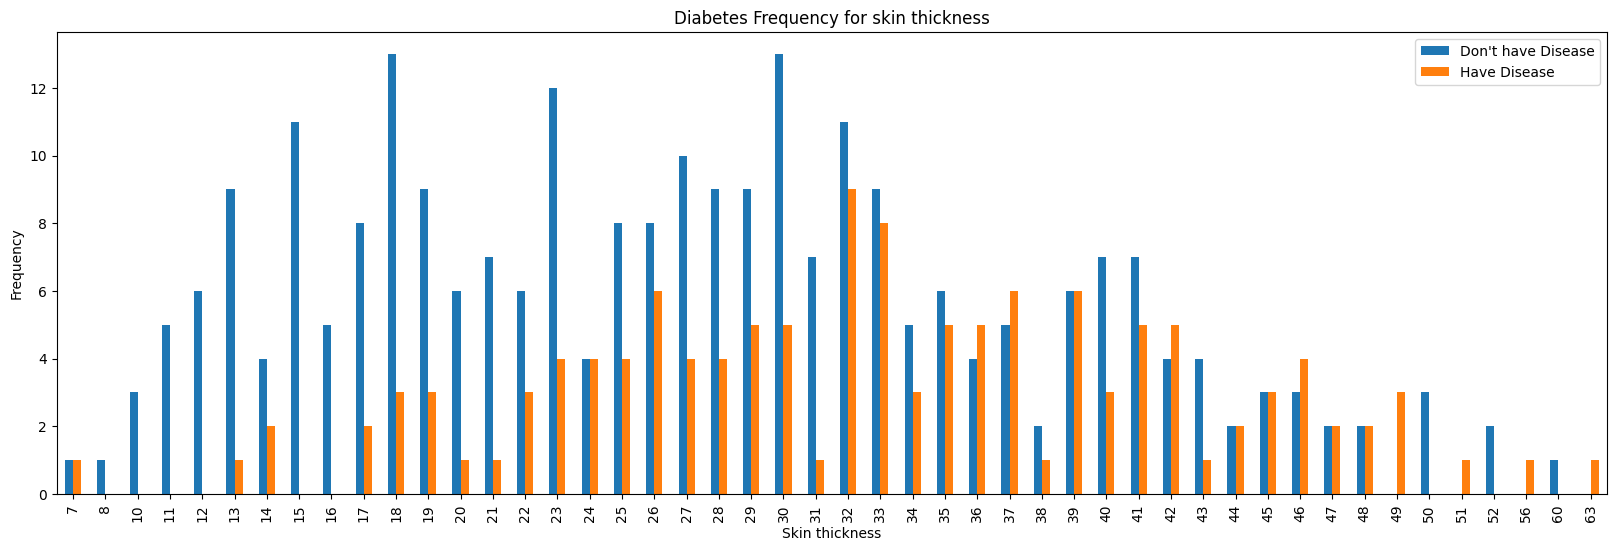

In [20]:
pd.crosstab(df2.SkinThickness, df2.Outcome).plot(kind="bar", figsize=(20, 6))
plt.title("Diabetes Frequency for skin thickness")
plt.xlabel("Skin thickness")
plt.ylabel("Frequency")
plt.legend(["Don't have Disease", "Have Disease"])
plt.show()

У людей с толстой кожей диабет встречается чаще: нет пациентов с диабетом в диапазоне 8-12, но замечается сильный рост заболевших начиная с 22.

Ранне мы увидели корреляцию между толщиной кожи и индексом массы тела. Посмотрим на их связь

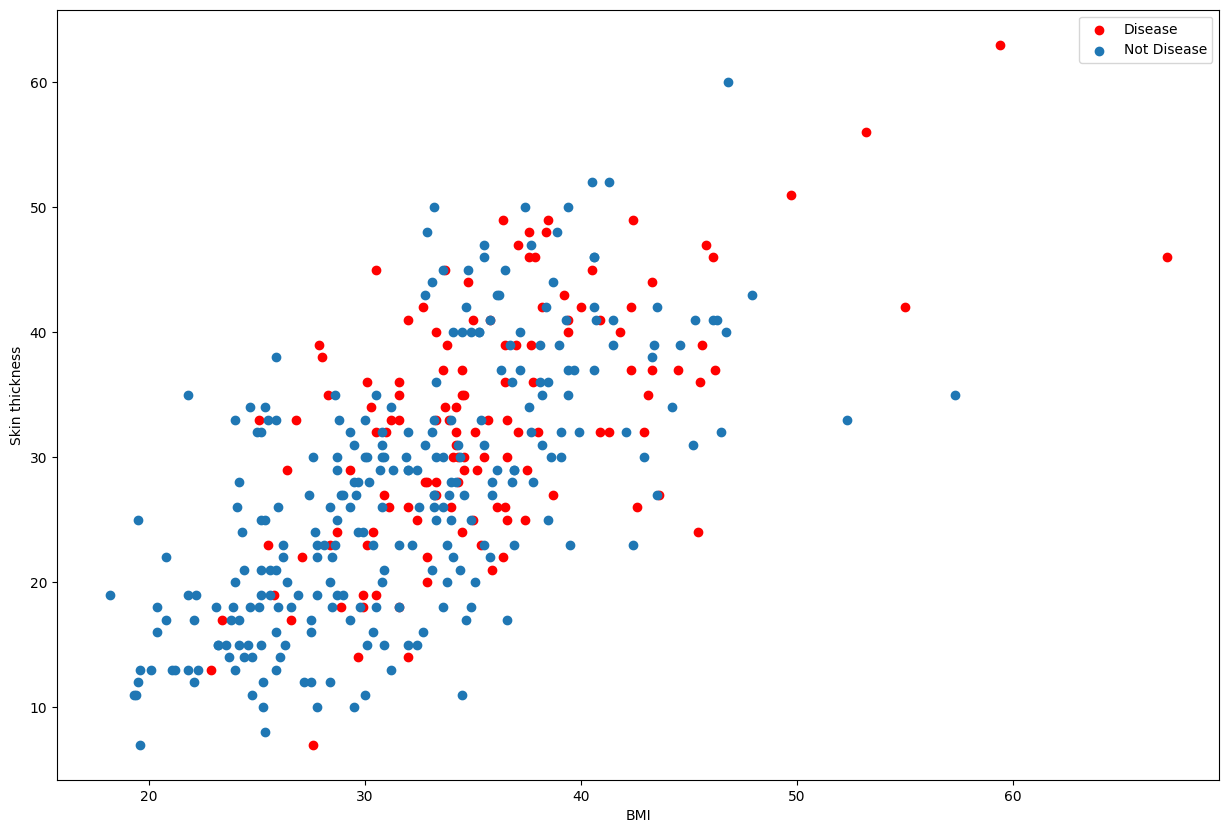

In [21]:
plt.scatter(
    x=df2.BMI[df2.Outcome == 1], y=df2.SkinThickness[(df2.Outcome == 1)], c="red"
)
plt.scatter(x=df2.BMI[df2.Outcome == 0], y=df2.SkinThickness[(df2.Outcome == 0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("BMI")
plt.ylabel("Skin thickness")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

Выглядит, как будто с увеличением массы тела увеличивается и толщина кожи человека, а также частота диабета у пациента. Например, при BMI < 30 вероятность диагноза у пациента значительно ниже, чем при > 30.

### Признак **DiabetesPedigreeFunction**

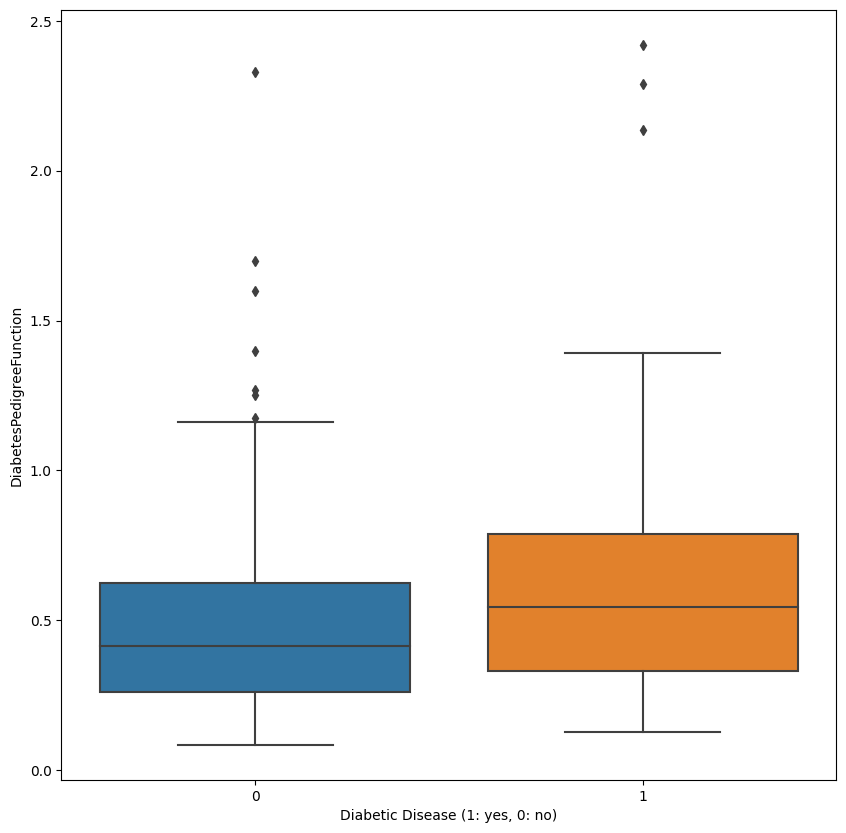

In [22]:
sns.boxplot(x="Outcome", y="DiabetesPedigreeFunction", data=df2)
plt.xlabel("Diabetic Disease (1: yes, 0: no)")
plt.ylabel("DiabetesPedigreeFunction")
fig = plt.gcf()
fig.set_size_inches(10, 10)

Признак **DiabetesPedigreeFunction** показывает, какова вероятность развития диабета по наследственности. Несмотря на достаточно низкую корреляю, все-таки можно увидеть, что среднее значение у болеющих людей выще, чем среднее значение у здоровых (0.62 vs 0.47).

### Выводы

**Pregnancies**: У женщин, которые перенесли больше чем 6 беременностей, выше вероятность заболеть диабетом;

**Glucose**: при показаниях выше 150 для всех возрастов риск болезни диабетом очень высокий. Для людей старше 30 лет риск болезни выше, так как она чаще встречается и при глюкозе, меньше 150;

**BloodPressure**: если у пациента давление 60-95, то шансы заболеть диабетом сильно увеличиваются после 30 лет;

**SkinThickness**: у людей с толстой кожей диабет встречается чаще: нет пациентов с диабетом в диапазоне 8-12, но замечается сильный рост заболевших начиная с 22;

**Insulin**: здоровые пациенты в основном сконцентрированы в низких показаниях инсулина;

**BMI**: с увеличением массы тела увеличивается и толщина кожи человека, а также частота диабета у пациента. Например, при BMI < 30 вероятность диагноза у пациента значительно ниже, чем при > 30;

**DiabetesPedigreeFunction**: среднее значение у болеющих людей выше, чем среднее значение у здоровых (0.62 vs 0.47);

**Age**: для пациентов 21-28 лет процент людей, которые не болеют сильно выше, чем для людей 28+. Для людей 51-54 лет заметно обратное: люди чаще получают диагноз диабет.

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from math import inf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import (
    SelectKBest,
    chi2,
    f_regression,
    RFECV,
    mutual_info_regression,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [31]:
accuracies = dict()

y = df2["Outcome"]
X = df2.drop(columns="Outcome")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1 / 3, random_state=54
)

In [32]:
scaler = StandardScaler()

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

X_scaled = scaler.transform(X)

## Реализация логистической регрессии

In [49]:
import warnings
import warnings
from scipy.special import softmax
from sklearn.preprocessing import OneHotEncoder


class MyLogReg:
    def __init__(self, learning_rate=0.01, epochs=250, l2=0.01, random_seed=59):
        self.__weights = []
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.random_seed = random_seed
        self.l2 = l2

    def getWeights(self):
        return self.__weights

    def __sigmoid(self, z):
        warnings.filterwarnings("ignore")
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):

        samples, _ = np.shape(X)

        features = np.c_[np.ones(samples), X]
        y_encode = OneHotEncoder(sparse=False).fit_transform(y.values.reshape(-1, 1))
        np.random.seed(self.random_seed)
        weights = np.random.random_sample((features.shape[1], y_encode.shape[1]))

        #         for epoch in range(self.epochs):
        #             z = X_full @ weights
        #             h = self.__sigmoid(z)
        #             gradient = (X_full.T @ (h - y)) / y.size
        #             weights -= self.learning_rate * gradient

        for epoch in range(self.epochs):
            z = features @ weights
            h = softmax(-z, axis=1)
            error = y_encode - h
            gradient = 1 / samples * (features.T @ error) + 2 * self.l2 * weights
            weights -= self.learning_rate * gradient

        self.__weights = weights
        return self

    def score(self, X, y):
        return (self.predict(X) == y).mean()

    # function name needed by GridSearch
    def predict_proba(self, X):
        features = np.c_[np.ones(X.shape[0]), X]
        return np.argmax(softmax(-features @ self.__weights, axis=1), axis=1)

    def predict(self, X):
        return self.predict_proba(X).astype(np.float64)

    def get_params(self, deep=False):
        return {
            "learning_rate": self.learning_rate,
            "epochs": self.epochs,
            "random_seed": self.random_seed,
            "l2": self.l2,
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [50]:
param_grid = {
    "learning_rate": [0.00001, 0.0001, 0.001, 0.01, 0.1],
    "epochs": [2000, 20000, 200000],
    "l2": [0.1, 0.01, 0.001, 0.0001],
}

gs = GridSearchCV(
    MyLogReg(),
    return_train_score=True,
    error_score="raise",
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
)

%time gs.fit(X_train_scaled, y_train)

print("=" * 20)
print("best params: " + str(gs.best_params_))
print("best score:", gs.best_score_)
print("=" * 20)

# best params: {'epochs': 2000, 'l2': 0.1, 'learning_rate': 0.01}
# best score: 0.7855639976621858

CPU times: user 1.15 s, sys: 170 ms, total: 1.32 s
Wall time: 2min 6s
best params: {'epochs': 2000, 'l2': 0.1, 'learning_rate': 0.01}
best score: 0.7855639976621858


In [58]:
model_lr = MyLogReg(**gs.best_params_)
model_lr.fit(X_train_scaled, y_train)

acc = model_lr.score(X_test_scaled, y_test)
accuracies["MyLogReg"] = acc
acc

0.7244897959183674

## Реализация KNN

In [36]:
# Euclidean distance
def default_distance(point, data):
    return np.sqrt(np.sum((point - data) ** 2, axis=1))


class MyKNN:
    def __init__(self, k_neighbors=5, dist_func=None):
        self.k_neighbors = k_neighbors
        self.dist_func = default_distance if dist_func is None else dist_func

    def __most_common(self, lst):
        return max(lst, key=lst.count)

    def score(self, X, y):
        return (self.predict(X) == y).mean()

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.k_neighbors = min(self.k_neighbors, np.shape(X)[0])

        return self

    def predict_proba(self, X):
        return self.predict(X).astype(np.float64)

    def predict(self, X):
        neighbors = []
        for point in X:
            distances = self.dist_func(point, self.X_train)
            y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
            neighbors.append(y_sorted[: self.k_neighbors])

        return np.array(list(map(self.__most_common, neighbors)))

    def get_params(self, deep=False):
        return {
            "k_neighbors": self.k_neighbors,
            "dist_func": self.dist_func,
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [37]:
param_grid = {"k_neighbors": np.arange(1, 20, 1)}

my_knn = MyKNN()

gs = GridSearchCV(
    my_knn,
    return_train_score=True,
    error_score="raise",
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
)

%time gs.fit(X_train_scaled, y_train)
my_knn.set_params(**gs.best_params_)
my_knn.fit(X_train_scaled, y_train)
acc = my_knn.score(X_test_scaled, y_test)
accuracies["MyKNN"] = acc

print("=" * 20)
print("best params: ", gs.best_params_)
print("best score:", gs.best_score_)
print("test score:", acc)
print("=" * 20)

CPU times: user 200 ms, sys: 3.99 ms, total: 204 ms
Wall time: 355 ms
best params:  {'k_neighbors': 9}
best score: 0.7822326125073056
test score: 0.7653061224489796


### Гиперпараметры для библиотечных методов

In [38]:
# logreg

from sklearn.linear_model import LogisticRegression

param_grid = {"C": np.arange(1e-05, 5, 0.1)}
scoring = {"Accuracy": "accuracy", "AUC": "roc_auc", "Log_loss": "neg_log_loss"}

log_reg = LogisticRegression()

gs = GridSearchCV(
    log_reg,
    return_train_score=True,
    param_grid=param_grid,
    scoring=scoring,
    cv=5,
    refit="Accuracy",
)

gs.fit(X_train_scaled, y_train)
log_reg.set_params(**gs.best_params_)
log_reg.fit(X_train_scaled, y_train)

acc = log_reg.score(X_test_scaled, y_test)
accuracies["LogReg"] = acc

print("=" * 20)
print("best params: ", gs.best_params_)
print("best score:", gs.best_score_)
print("test score:", acc)
print("=" * 20)

best params:  {'C': 0.30001000000000005}
best score: 0.7753945061367622
test score: 0.7346938775510204


In [39]:
# KNN

from sklearn.neighbors import KNeighborsClassifier

n_neighbors = np.arange(1, 10, 1)
weights = ["uniform", "distance"]

knn = KNeighborsClassifier()

gs = GridSearchCV(
    knn,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    param_grid=dict(n_neighbors=n_neighbors, weights=weights),
    refit="Accuracy",
)

gs.fit(X_train_scaled, y_train)
knn.set_params(**gs.best_params_)
knn.fit(X_train_scaled, y_train)

acc = knn.score(X_test_scaled, y_test)
accuracies["KNN"] = acc

print("=" * 20)
print("best params: " + str(gs.best_params_))
print("best score:", gs.best_score_)
print("test score:", acc)
print("=" * 20)

best params: {'n_neighbors': 9, 'weights': 'uniform'}
best score: 0.7890122735242547
test score: 0.7653061224489796


In [40]:
# naive bayes

from sklearn.naive_bayes import GaussianNB

var_smoothing = np.logspace(0, -9, num=100)

nb = GaussianNB()

gs = GridSearchCV(
    nb,
    cv=5,
    return_train_score=True,
    param_grid=dict(var_smoothing=var_smoothing),
    scoring=scoring,
    refit="Accuracy",
)

gs.fit(X_train_scaled, y_train)
nb.set_params(**gs.best_params_)
nb.fit(X_train_scaled, y_train)

acc = nb.score(X_test_scaled, y_test)
accuracies["Naive Bayes"] = acc

print("=" * 20)
print("best params: " + str(gs.best_params_))
print("best score:", gs.best_score_)
print("test score:", acc)
print("=" * 20)

best params: {'var_smoothing': 0.04328761281083057}
best score: 0.7787843366452367
test score: 0.7346938775510204


In [41]:
# decision tree

from sklearn.tree import DecisionTreeClassifier

criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]
max_depth = np.arange(2, 20, 2)
min_samples_split = np.arange(2, 10, 2)
min_samples_leaf = np.arange(1, 8, 2)
max_features = np.arange(2, 8, 2)

decision_tree = DecisionTreeClassifier(random_state=17)
gs = GridSearchCV(
    decision_tree,
    cv=5,
    return_train_score=True,
    param_grid=dict(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
    ),
    scoring=scoring,
    refit="Accuracy",
    n_jobs=-1,
)
%time gs.fit(X_train_scaled, y_train)

decision_tree.set_params(**gs.best_params_)
decision_tree.fit(X_train_scaled, y_train)

acc = knn.score(X_test_scaled, y_test)
accuracies["DecisionTree"] = acc

print("=" * 20)
print("best params: " + str(gs.best_params_))
print("best score:", gs.best_score_)
print("test score:", acc)
print("=" * 20)

CPU times: user 3.14 s, sys: 131 ms, total: 3.27 s
Wall time: 5.71 s
best params: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'random'}
best score: 0.7755113968439509
test score: 0.7653061224489796


In [42]:
# SVM

from sklearn.svm import SVC

C = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel = ["linear", "rbf"]
gamma = ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1]

svm = SVC(random_state=0)
gs = GridSearchCV(
    svm,
    cv=5,
    return_train_score=True,
    param_grid=dict(kernel=kernel, C=C, gamma=gamma),
    n_jobs=-1,
)
%time gs.fit(X_train_scaled, y_train)

svm.set_params(**gs.best_params_)
svm.fit(X_train_scaled, y_train)

acc = svm.score(X_test_scaled, y_test)
accuracies["SVM"] = acc

print("=" * 20)
print("best params: " + str(gs.best_params_))
print("best score:", gs.best_score_)
print("test score:", acc)
print("=" * 20)

CPU times: user 163 ms, sys: 9.34 ms, total: 172 ms
Wall time: 206 ms
best params: {'C': 0.25, 'gamma': 'scale', 'kernel': 'linear'}
best score: 0.7856224430157802
test score: 0.7448979591836735


## Сравнение моделей

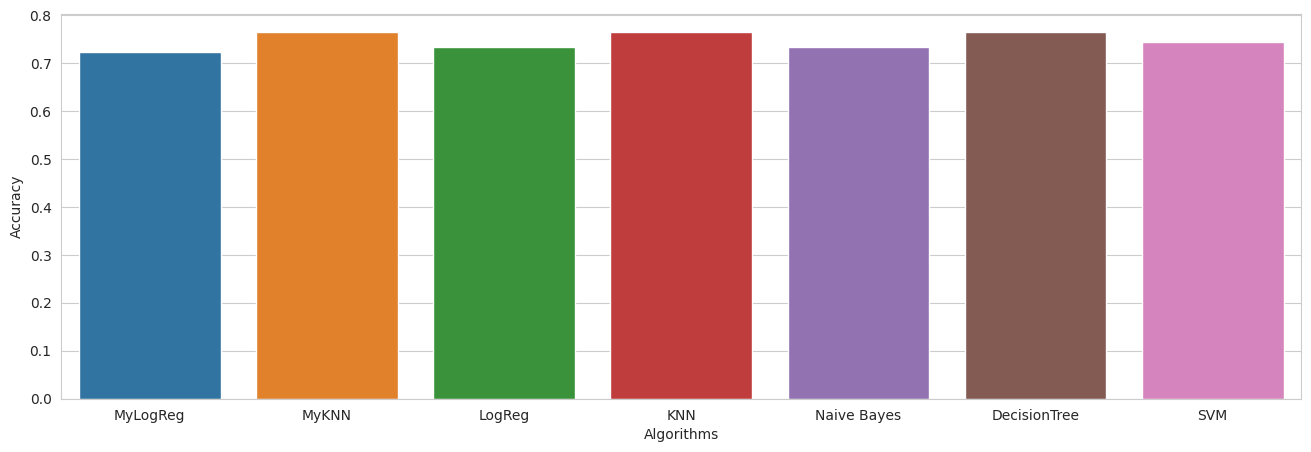

In [54]:
# colors = ["purple", "green", "orange", "magenta", "blue"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.show()

## Confusion Matrix

In [55]:
y_head_lr = log_reg.predict(X_test_scaled)
y_head_knn = knn.predict(X_test_scaled)
y_head_svm = svm.predict(X_test_scaled)
y_head_nb = nb.predict(X_test_scaled)
y_head_decision_tree = decision_tree.predict(X_test_scaled)
y_head_mylr = model_lr.predict(X_test_scaled)
y_head_myknn = my_knn.predict(X_test_scaled)

In [56]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_head_lr)
cm_knn = confusion_matrix(y_test, y_head_knn)
cm_svm = confusion_matrix(y_test, y_head_svm)
cm_nb = confusion_matrix(y_test, y_head_nb)
cm_decision_tree = confusion_matrix(y_test, y_head_decision_tree)
cm_mylr = confusion_matrix(y_test, y_head_mylr)
cm_myknn = confusion_matrix(y_test, y_head_myknn)

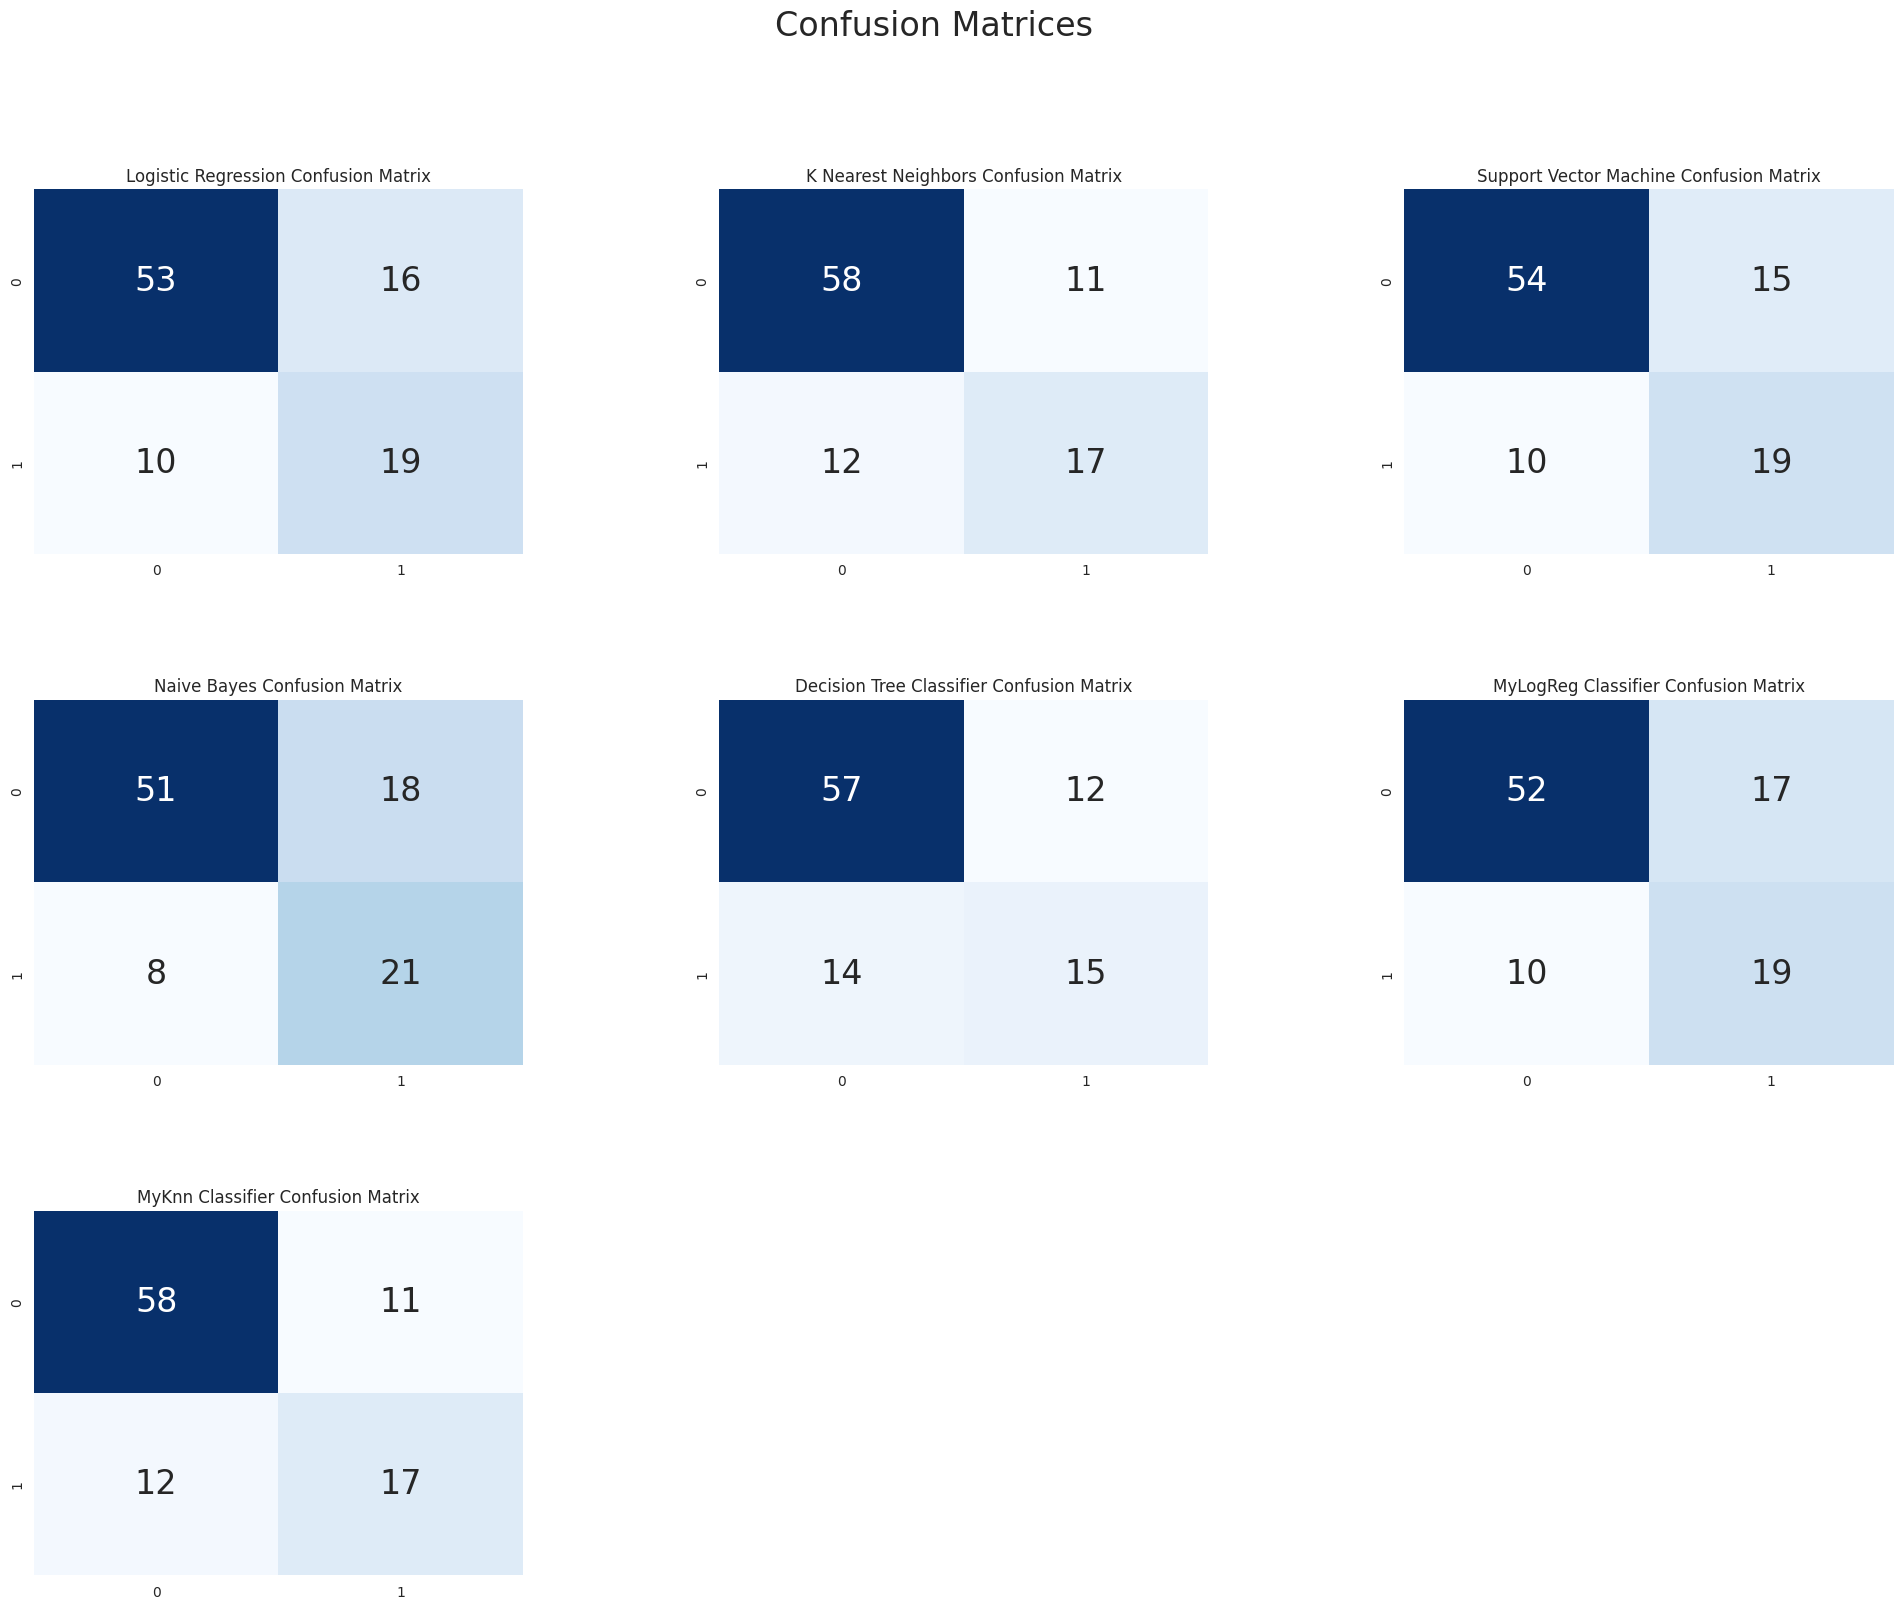

In [57]:
plt.figure(figsize=(24, 18))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(3, 3, 1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(
    cm_lr, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24}
)

plt.subplot(3, 3, 2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(
    cm_knn, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24}
)

plt.subplot(3, 3, 3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(
    cm_svm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24}
)

plt.subplot(3, 3, 4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(
    cm_nb, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24}
)

plt.subplot(3, 3, 5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(
    cm_decision_tree,
    annot=True,
    cmap="Blues",
    fmt="d",
    cbar=False,
    annot_kws={"size": 24},
)

plt.subplot(3, 3, 6)
plt.title("MyLogReg Classifier Confusion Matrix")
sns.heatmap(
    cm_mylr, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24}
)

plt.subplot(3, 3, 7)
plt.title("MyKnn Classifier Confusion Matrix")
sns.heatmap(
    cm_myknn, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24}
)

plt.show()

## Выводы

По сравнению с данными heart.csv, все модели работают хуже на выбранных нами данных, но всё равно дают точность >70%.
Наши реализации вновь не уступают по точности  бибилиотечным реализациям с оптимальными гиперпараметрами.

Так же на выбранных данных отрыв KNN, SVM и Decision Tree куда менее заметен, чем на первом датасете.
